# Lecture 1

Settings that make the plots look pretty on my Mac:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


You will need 

* [corner](https://github.com/dfm/corner.py).  Makes "corner" plots of distributions from samples.
* [pystan](https://pystan.readthedocs.io/en/latest/).  `pip install pystan` has always worked well for me.  (If you need a good Python distribution, I recommend [anaconda](https://www.continuum.io), which comes with a complete `numpy`, `scipy`, `iPython`, etc stack.
* [seaborn](https://seaborn.pydata.org).  `pip install seaborn`.  Seaborn is a plotting library.

In [20]:
import corner
import pystan
import seaborn as sns

These are my favourite plotting styles:

In [66]:
sns.set_context('talk') #sns.set_context('notebook') is probably better on your monitor
sns.set_palette('colorblind')
sns.set_style('ticks')

## Preliminaries (Notes)

* $p(d, \theta) = p\left( d \mid \theta \right) p\left( \theta \right) = p\left( \theta \mid d \right) p\left( d \right)$ is the fundamental quantity.  A "just so" story about how you obtained your data.
* Dimensions / forms.
* Sampling from versus writing down; normalisation.
* Almost always computing.
* One way to think about it is that $p$ describes *knowledge*.  For example:
  * If I knew $\theta$, what would I predict about $d$.
  * If I knew $d$, what would I predict about $\theta$.
* Marginalisation.

## Let's Get Started Fitting

We are going to focus today on [Hogg, et al. (2010)](https://arxiv.org/abs/1008.4686).  In this paper, the "just so" story will be evolving, but it always involves measuring data `x` and `y` which are (often) related by a linear relationship:
$$
y = m x + b
$$
For some reason (maybe we are cosmologists?) we are interested in the parameters $m$ and $b$.  Please read Hogg, et al. (2010)'s cautionary note about this!

* Warning about interpretation of b (we will explore this)!

I used [tabula](http://tabula.technology) to scrape the data table from Hogg's PDF.  When *you* post things on the arXiv, *you* should always include a link to machine readable tables to accompany the document.  You can post your data on [GitHub](https://github.com), or if you want more archive-quality repositories that are citable (e.g. generate a DOI), consider something like [Zenodo](https://zenodo.org).  Hogg & company, normally so good in this respect, dropped the ball for this paper.

In [67]:
table1 = genfromtxt('HoggTable1.tsv', names=True)

<Container object of 3 artists>

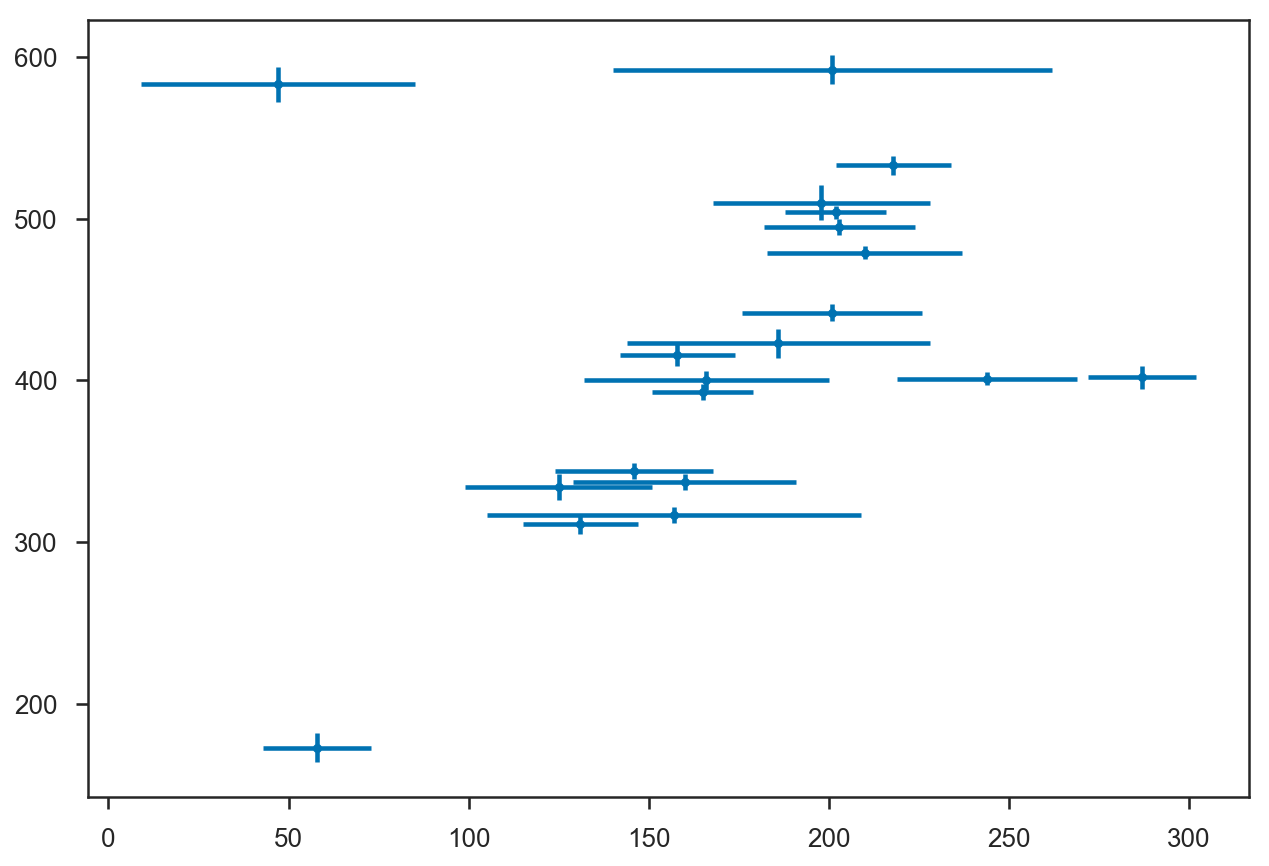

In [68]:
errorbar(table1['x'], table1['y'], xerr=table1['sigma_x'], yerr=table1['sigma_y'], fmt='.')

### Exercise 1

(I know that this can be computed analytically---and Hogg, et al. (2010) tell you how---but we're going to be computing anyway, so let's do it that way first.)

To do some fits, we will be using [Stan](http://mc-stan.org) (named, by the way for [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam)).  Stan is a specialised language for describing joint distributions of data and parameters.  Once the description is written down, Stan compiles the description to a C++ program that draws samples from the conditional distribution $p\left( \theta \mid d \right)$; a C++ compiler on your machine translates that into executable code, which we then drive from Python.  Whew.

For exercise 1, we assume that 
$$
y_\mathrm{true} = m x_\mathrm{true} + b
$$
and 
$$
y_\mathrm{obs} = y_\mathrm{true} + \sigma_y
$$

* Write stan program.

In [69]:
model = pystan.StanModel(file='linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70a875d88505bb180d2df34c7eae85a1 NOW.


Exercise 1 asks us to fit all the data from the 5th to the 20th point, and ignore the uncertainty in $y$.

In [70]:
ex1N0 = 4

In [71]:
ex1_data = {'npts': table1['x'][ex1N0:].shape[0],
            'xs': table1['x'][ex1N0:],
            'ys': table1['y'][ex1N0:],
            'sigma_ys': table1['sigma_y'][ex1N0:]}

Inference for Stan model: anon_model_70a875d88505bb180d2df34c7eae85a1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      2.33  1.6e-3   0.04   2.24    2.3   2.33   2.35   2.41    654    1.0
b      4.31    0.29   7.49  -9.86   -0.7   4.13   9.34  19.06    659    1.0
lp__ -202.3    0.03   0.98 -204.9 -202.8 -202.0 -201.6 -201.4   1014    1.0

Samples were drawn using NUTS at Mon Jul 10 12:01:18 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

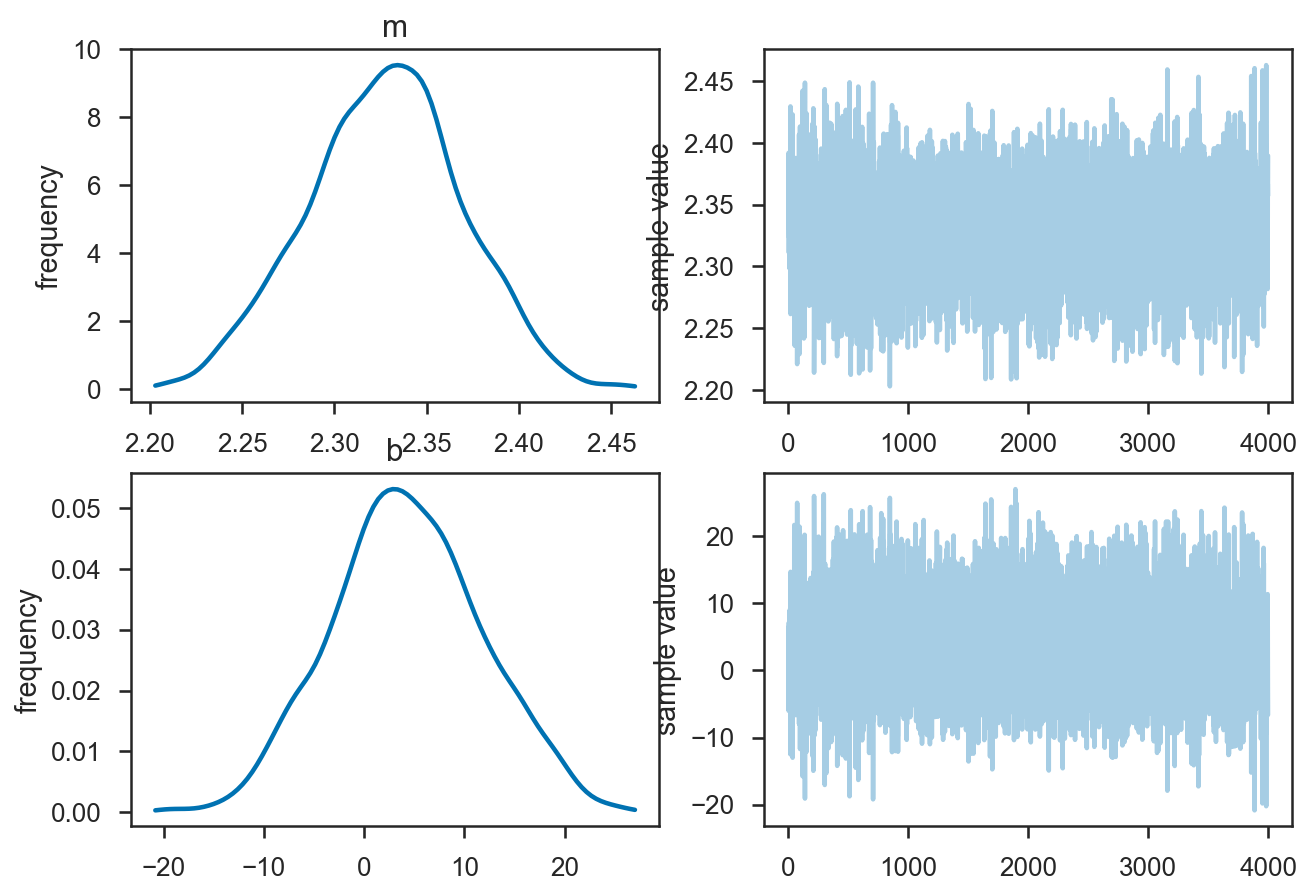

In [72]:
ex1_fit = model.sampling(data=ex1_data)
ex1_fit.plot()
ex1_fit

In [73]:
ex1_samples = ex1_fit.extract(permuted=True)

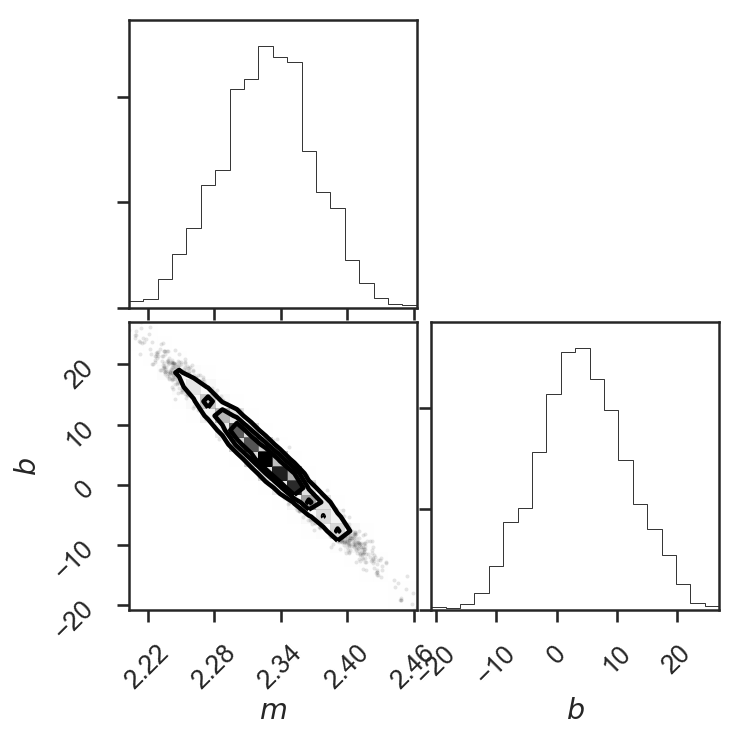

In [74]:
corner.corner(column_stack((ex1_samples['m'], ex1_samples['b'])), labels=[r'$m$', r'$b$']);

We *always* want to plot the output of our models in data space, to check whether the fit is good.  Let's define a function that does this:

In [75]:
def plot_errorbands(xs, ms, bs, *args, **kwargs):
    ys = []
    for m,b in zip(ms, bs):
        ys.append(m*xs + b)
    ys = array(ys)
    
    line, = plot(xs, median(ys, axis=0), *args, **kwargs)
    fill_between(xs, percentile(ys, 84, axis=0), percentile(ys, 16, axis=0), alpha=0.25, color=line.get_color())
    fill_between(xs, percentile(ys, 97.5, axis=0), percentile(ys, 16, axis=0), alpha=0.25, color=line.get_color())

A somewhat subtle point: our model has *implications* for $y_\mathrm{true}$.  $y_\mathrm{true} = m x + b$.  Thus we have a posterior on $y_\mathrm{true}$:

In [76]:
def plot_ytrues_no_scatter(xs, ms, bs, *args, **kwargs):
    ytrues = []
    for m,b in zip(ms, bs):
        ytrues.append(m*xs + b)
    ytrues = array(ytrues)
    
    errorbar(xs, mean(ytrues, axis=0), yerr=std(ytrues, axis=0), fmt='.', *args, **kwargs)

<Container object of 3 artists>

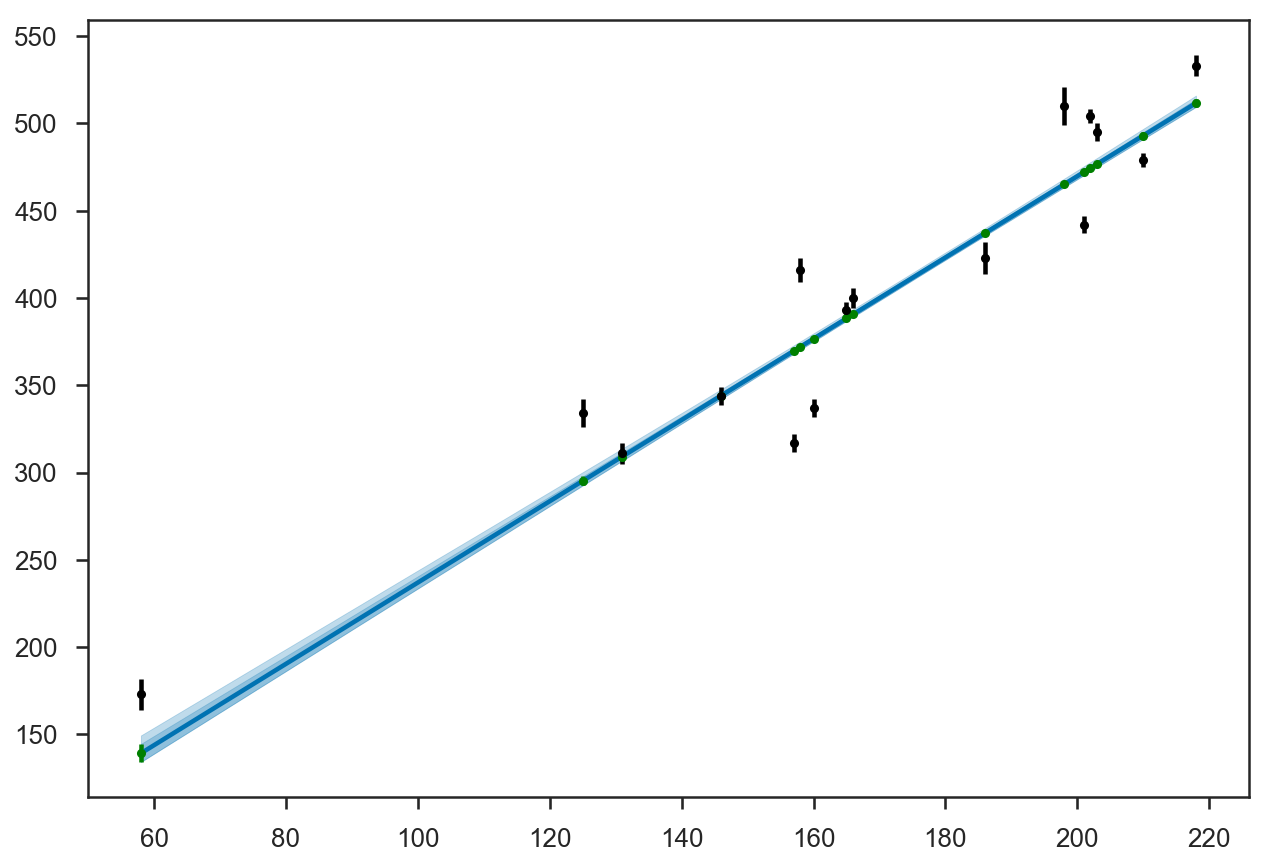

In [77]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), ex1_samples['m'], ex1_samples['b'])
plot_ytrues_no_scatter(table1['x'][ex1N0:], ex1_samples['m'], ex1_samples['b'], color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

Places to go from here:
* Exercise 2: Fit the crappy data.
* Improve the model (it's obviously bad)?
* Better priors?
* Deal with outliers.